# **Filtering and Isolating Stance Phase From Force Plate Walking Data** #
### By Ben Lutzko ###

In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walk-data/S1_Walk_100PSL.mat


## Import Matplotlib, and Some Signal Processing ##

In [61]:
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import butter, filtfilt

# Asses Data #
- import data
- plot data to inspect
- Define Axes



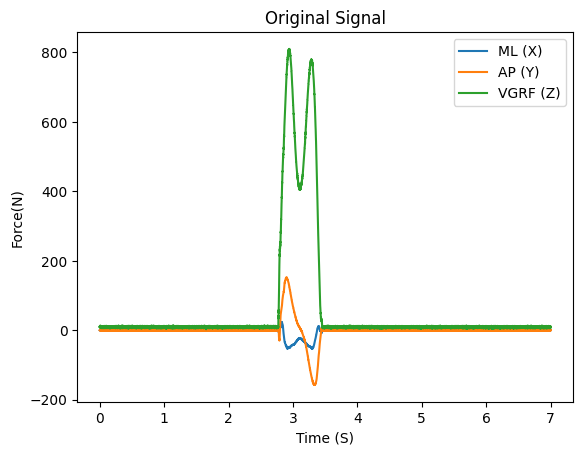

In [62]:
# Load .mat file
mat = scipy.io.loadmat("/kaggle/input/walk-data/S1_Walk_100PSL.mat")

# Access variables in the .mat file
# For example, if the variable name is 'data'
S1W = mat['data']

# Create Time Vector for data that was sampled at 2400hz
time = np.arange(0, len(S1W[:,0])/2400, 1/2400)

# Create Original plot to inspect
plt.plot(time, S1W) # plot to look at signal 
plt.title('Original Signal')
plt.ylabel('Force(N)')
plt.xlabel('Time (S)')
plt.legend(['ML (X)','AP (Y)','VGRF (Z)'])

# Filter Signal # 
- Zoom in to inspect orignal filter
- Filter at 14Hz as is a walking trial
    - walking is typically around 6Hz 
- Compare with original signal on a subplot

(7400.0, 7600.0)

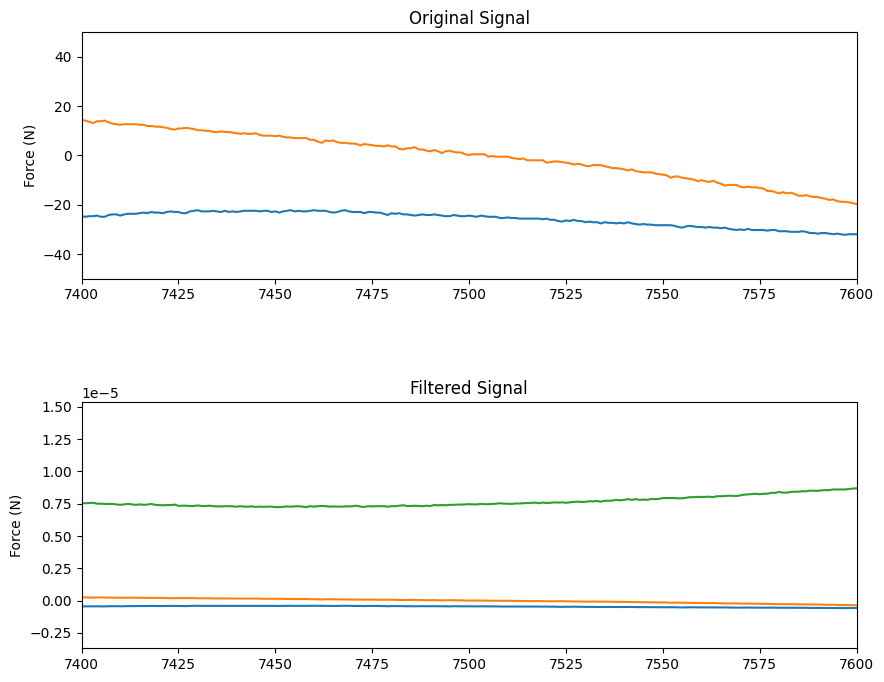

In [63]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
fig.subplots_adjust(hspace=0.5)

# Re-Plot the original signal but zoomed in to look at noise
axs[0].plot(S1W)
axs[0].set_title('Original Signal')
axs[0].set_ylabel('Force (N)')
axs[0].set_xlim(7400, 7600)
axs[0].set_ylim(-50, 50)


# normalize signal to filter 
max_value = np.max(S1W)
normalized_signal = S1W / max_value

# first create a filter with butter
b, a = butter( 2, 14/(2400*0.5), btype='low', analog='false') # cut off at 14 hz 

# Apply filter
S1Wx = filtfilt(b,a, normalized_signal[:,0])
S1Wy = filtfilt(b,a, normalized_signal[:,1])
S1Wz = filtfilt(b,a, normalized_signal[:,2])

# Create filtered signal variable back to a x,y,z matrix
S1Wfilter_N = np.column_stack((S1Wx, S1Wy, S1Wz))
S1Wfilter = S1Wfilter_N*max_value # De-normalize

#Check Filter by plotting a zoomed in plot of filtered signal
axs[1].plot(S1Wfilter)
axs[1].set_title("Filtered Signal")
axs[1].set_ylabel("Force (N)")
axs[1].set_xlim(7400,7600)

### Filter worked so move onto next section ###

# Find and Plot Stance Phase #
- find appropriate threshold 
- use idx to plot each axis
- repeat for the filtered signal

[[ 1.74940905e-08 -9.11724168e-09  2.65078858e-07]
 [ 8.52418912e-09 -9.11785696e-09  2.65081319e-07]
 [-1.28288095e-08  6.96866015e-08  3.33023212e-07]
 ...
 [-7.44264755e-08  9.61481322e-08  3.13415298e-07]
 [-6.55305524e-08  8.28785325e-08  3.51373662e-07]
 [-6.13048314e-08  8.33230143e-08  2.97402608e-07]]


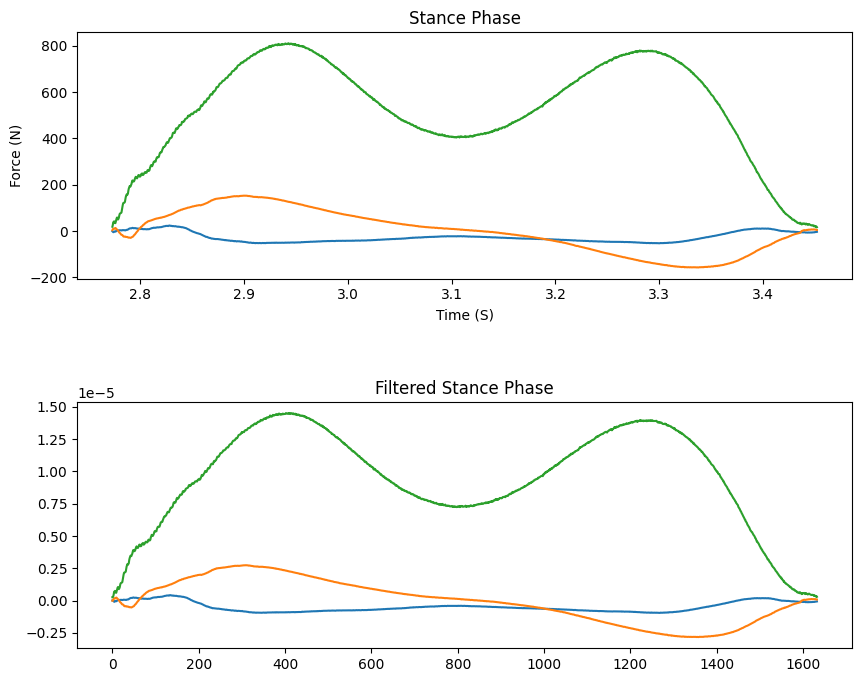

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
fig.subplots_adjust(hspace=0.5)

# Found that 15 is a good threshold to define stance phase
threshold = 15
indices_z = np.where(S1W[:, 2] > threshold)[0]  # Get indices where column 2 > threshold

S1Wxx = S1W[:,0]
S1Wyy = S1W[:,1]
S1Wzz = S1W[:,2]

# index for each column to isolate stance phase 
StanceDataX = S1Wxx[indices_z]
StanceDataY = S1Wyy[indices_z]
StanceDataZ = S1Wzz[indices_z]

# turn back into a matrix
S1WStance = np.column_stack((StanceDataX,StanceDataY, StanceDataZ))


StanceTime = time[indices_z]
axs[0].plot(StanceTime, S1WStance)
axs[0].set_title('Stance Phase')
axs[0].set_ylabel('Force (N)')
axs[0].set_xlabel('Time (S)')

# Do the same for filtered signal 
# FIX SO CAN USE SAME CUT OFF

fmax = np.max(S1Wfilter[:,2])
fmin = np.min(S1Wfilter[:,2])

ff = np.min(S1W[:,2])

Fis = np.where(S1Wfilter[:,2] > (5*10**-8)*5)

Xi = S1Wfilter[:,0]
Yi = S1Wfilter[:,1]
Zi = S1Wfilter[:,2]

X = Xi[Fis]
Y = Yi[Fis]
Z = Zi[Fis]

F_Stance = np.column_stack((X, Y, Z))
axs[1].plot(F_Stance)
axs[1].set_title('Filtered Stance Phase')
print(F_Stance)
